In [3]:
#import dependencies
# import plotly.graph_objects as go
# import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'image.cmap': 'cubehelix'})
sns.set_context('poster')
plt.style.use('seaborn-whitegrid')
import os
import pandas as pd
# import numpy as np
import requests
import json
import time
import pprint
from census import Census
from us import states
from census_config import census_key
# import plotly
# from scipy import interpolate
import geopandas as gp
# from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union
# import shapely.wkt

In [4]:
#read data pulled from API to dataframe
df = pd.read_csv('data.csv')
#drop columns consisting of more than 90% N/A values
df.dropna(thresh=int(df.shape[0] * .9), axis=1, inplace=True)
df.head()

,Unnamed: 0,Population,Zip_Codes,Poverty Rate,stop_id,stop_code,stop_name,lat,lon
0,0,77779,78613,3.783798,5698,5698,ACC Cypress Creek,30.479477,-97.834422
1,1,27900,78617,17.258065,3238,3238,Travis Correctional Facility,30.197840,-97.645546
2,2,27900,78617,17.258065,3240,3240,3103 SH 71/Cheviot,30.205035,-97.642589
3,3,27900,78617,17.258065,3241,3241,2777 SH 71/Golf Course,30.210895,-97.654067
4,4,27900,78617,17.258065,3323,3323,3320 FM 973/SH 71,30.200884,-97.640493


In [19]:
#convert latitude and longitude values to NumPy Arrays
lat = np.array(df['lat'], dtype=float)
lon = np.array(df['lon'], dtype=float)
poverty = np.array(df['Poverty Rate'], dtype=float)

In [80]:
#read in coordinate data pulled from data.austintexas.gov
austin = pd.read_csv('austin.csv')
austin

,the_geom,OBJECTID,JURISDICTIONS_ID,CITY_NAME,JURISDICTION_LABEL,MODIFIED_FIPS,JURISDICTION_TYPE_SPECIFICS,JURISDICTION_TYPE,Shape__Area,Shape__Length
0,MULTIPOLYGON (((-97.835007783852 30.2980755155...,209,133,CITY OF AUSTIN,AUSTIN LTD,211,LIMITED PURPOSE PLANNING ZONING HEALTH SAFETY,LTD,1.829295e+06,9422.603500
1,MULTIPOLYGON (((-97.821982860402 30.3402980711...,100,467,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,1.116094e+06,5107.203192
2,MULTIPOLYGON (((-97.829183244603 30.3651655160...,428,400359621,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,2.921849e+07,30032.188879
3,MULTIPOLYGON (((-97.763973193996 30.4753309076...,401,439,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,6.766228e+07,61785.580474
4,MULTIPOLYGON (((-97.778155988634 30.3927488743...,94,156,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,4.509143e+05,2950.287054
...,...,...,...,...,...,...,...,...,...,...
194,MULTIPOLYGON (((-97.56334531696 30.30385652219...,400,375,CITY OF AUSTIN,AUSTIN LTD,211,LIMITED PURPOSE PLANNING ZONING,LTD,7.938176e+07,46744.266126
195,MULTIPOLYGON (((-97.628028128668 30.3543323626...,495,400630281,CITY OF AUSTIN,AUSTIN FULL PURPOSE,210,FULL PURPOSE,FULL,7.162866e+06,13028.978932
196,MULTIPOLYGON (((-97.699860938373 30.1327892144...,221,540,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,7.595161e+06,14031.611794
197,MULTIPOLYGON (((-97.716368653205 30.1331554896...,276,544,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,1.087012e+05,1487.502390


In [84]:
#pull the geomtry column of resulting dataframe to get multipolygon of 
#austin city limit coordinates
geom = austin['the_geom'][184]
#parse coordinates into workable data type using parse as a shapely method
A = shapely.wkt.loads(geom)
#separate the lon & lat into xx and yy respestively and grab the exterior
#and not the inside of the shape
xx, yy = A[0].exterior.xy

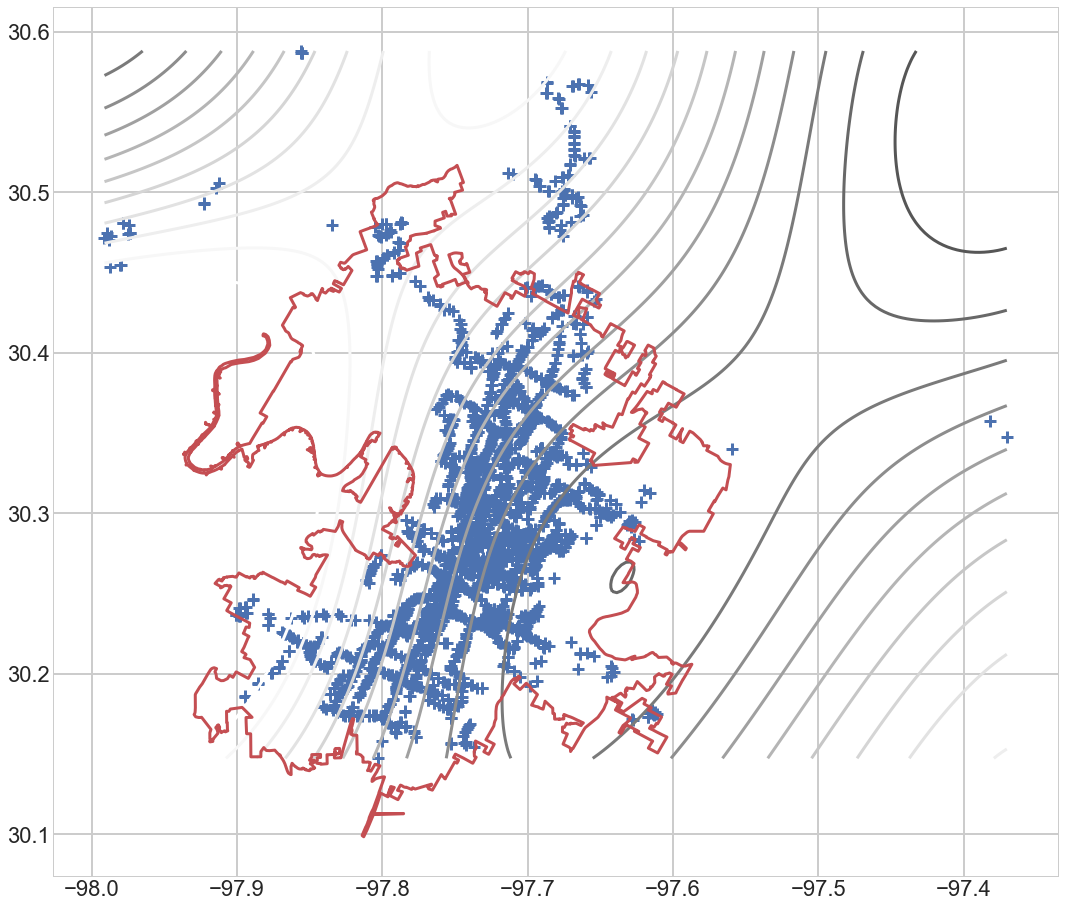

In [88]:
average_poverty = np.average(poverty)
lon_fake = -97.7 + 0.5 * np.cos(np.linspace(0, 2.0 * np.pi, 100))
lat_fake = 30.3 + 0.5 * np.sin(np.linspace(0, 2.0 * np.pi, 100))

f = interpolate.interp2d(
    np.concatenate((lon, lon_fake)),
    np.concatenate((lat, lat_fake)),
    np.concatenate((poverty, average_poverty * np.ones((100,)))),
    kind='cubic'
)
x = np.linspace(np.min(lon), np.max(lon), 200)
y = np.linspace(np.min(lat), np.max(lat), 200)
z = f(x, y)

plt.figure(figsize=(18,16))
plt.contour(x, y, z, levels=np.linspace(0, 40, 16))

plt.scatter(lon, lat, marker='+')

plt.plot(xx, yy, color='r')

plt.grid(True)